<div align="center"><h1>Control Engineering Basics</h1>
<br><b>Dr.Varodom Toochinda</b>
<br>Dept. of Mechanical Engineering, Kasetsart University</div>

### Supplement to Module 4 : Discrete-time PID implementation 

<a href="https://colab.research.google.com/github/dewdotninja/control_python/blob/master/adv_pid_implement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Requirement : </b> Python 3 with Python control systems library
<p />Execute the commands below to install Python control systems library in Colab    

In [ ]:
!pip install control

In [1]:
import control as ctl 
import numpy as np
import matplotlib.pyplot as plt

From the autotuning result with third order-lag plant
$$
P(s) = \frac{1}{(s+1)^3},
$$

In [4]:
pnum = 1
lag1 = [1,1]   # (s+1)
pden = np.convolve(lag1, lag1)  # (s+1)^2
pden = np.convolve(pden, lag1)  # (S+1)^3
P = ctl.tf(pnum,pden)


we get $K_u = 8$ and $T_u = 3.7$

Verify by forming a PID feedback with the plant. Define a function as follows.

In [2]:
# PID controller function
def pid(Kp, Ki, Kd, P, tvec):
    cnum = [Kd, Kp, Ki] 
    cden = [0, 1, 0]
    C = ctl.tf(cnum,cden)

    
    r = np.ones(tvec.shape)
    L = C*P
    sys = ctl.feedback(L)
    #print(sys)
    T, y = ctl.step_response(sys, tvec)

    plt.figure()
    plt.plot(T,r,'b',T,y,'r-')
    plt.grid('True')
    plt.xlabel('time (sec)')
    plt.ylabel('output')
    
    plt.legend(['step ref.','y'])
    plt.show()

and then do the simulation with $K_p = K_u = 8$, and $K_i = K_d = 0$. 

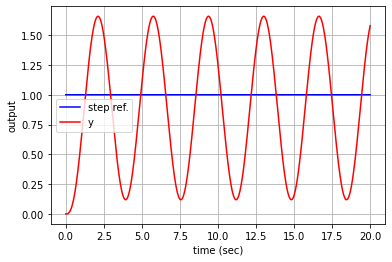

In [5]:
Kp = 8
Ki = 0
Kd = 0
tvec = np.arange(0,20,0.01)
pid(Kp, Ki, Kd, P, tvec)

The response does oscillate, with $T_u$ quite close to the oscillation from relay feedback; i.e., about 3.7 seconds. 
<p />We can see from this experiment how PID auto-tuning using relay feedback works. Using the adjusted values in Table 2 of 
module 4 yields the following response

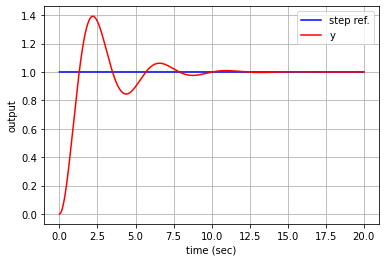

In [6]:
Ku = 8
Tu = 3.7
Kp = 0.6*Ku
Ki = 1.2*Ku/Tu
Kd = 0.075*Ku*Tu
tvec = np.arange(0,20,0.01)
pid(Kp, Ki, Kd, P, tvec)

As expected, the response from PID tuned by ZNFD method has significant overshoot.  

### Discrete-time implementation of PID controller

Figure 1 shows a Scilab/Xcos diagrom of PID controller with added features such as setpoint weightings 
and back calculation antiwindup scheme.

!["Fig 1"](https://drive.google.com/uc?id=1qVcZcbnwI0NLe1gCW6Ze7PKiVBUlFify)

Figure 1 PID controller with all features 

We can use the code below to implement this controller, just like you'd do 
on an MCU. 

In [9]:
# coefficient update
def PID_update():
    global ad, bd, bi, bt
    bi = 0.5*Ts*Ki
    bt = 0.5*Ts*Kt
    ad1 = 1+0.5*N*Ts 
    ad2 = 0.5*N*Ts - 1
    ad = -ad2/ad1
    bd = Kd*N/ad1

In [10]:
# PID controller function
def PID_controller(r,y):
    global e1,e0,ed1,ed0, eus1,eus0, ui1, ui0, ud1, ud0, u
    
    # state transfer
    e1 = e0
    ed1 = ed0
    eus1 = eus0
    
    ui1 = ui0
    ud1 = ud0
    # compute errors for each term
    e0 = r - y
    ep0 = Wp*r - y # weighted proportional error
    ed0 = Wd*r - y # weighted derivative error
    
    up0 = Kp*ep0 # output of P term
    ui0 = ui1 +bi*(e0+e1) + bt*(eus0+eus1) # output of I term
    ud0 = ad*ud1 +bd*(ed0 - ed1) # output of D term
    u = up0 + ui0 + ud0
    return u

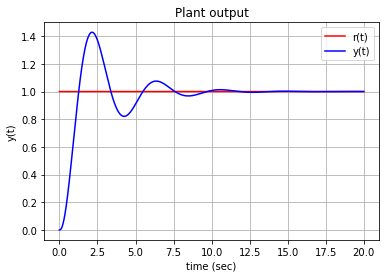

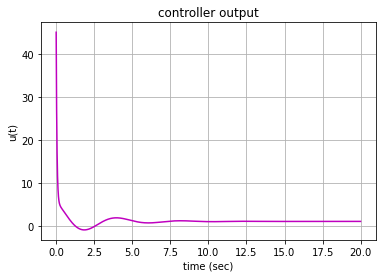

In [12]:
# --- 3rd-order-lag plant -----
pnum = 1
lag1 = [1,1]   # (s+1)
pden = np.convolve(lag1, lag1)  # (s+1)^2
pden = np.convolve(pden, lag1)  # (S+1)^3
P = ctl.tf(pnum,pden)

# ----- PID coefficients ------ 
Ku = 8
Tu = 3.7
Kp = 0.6*Ku
Ki = 1.2*Ku/Tu
Kd = 0.075*Ku*Tu
N = 20
Kt = 0
Wp = 1
Wd = 1

# coefficients used in PID uptate
bt = 0
bi = 0  
ad = 0
bd = 0

Ts = 0.01
PID_update()

# controller states
ep = 0  # error for proportional term
e1 = 0  # true error (for integral term)
e0 = 0
eus1 = 0 # error for back calculation term 
eus0 = 0
ed1 = 0  # error for derivative term
ed0 = 0
ui1 = 0  # integral-term outputs
ui0 = 0
ud1 = 0  # derivative-term outputs
ud0 = 0


# ----------------------------------

Pd = ctl.sample_system(P, Ts, method='tustin')
#print("Discrete-time plant")
#print(Pd)

Pdnum, Pdden = ctl.tfdata(Pd)
#print(Pdnum)
#print(Pdden)
pdnum = np.squeeze(np.array(Pdnum))
pdden = np.squeeze(np.array(Pdden))
tvec = np.arange(0,20,Ts)  # change time scale to suit
rvec = np.ones(tvec.shape)
yvec = np.zeros(tvec.shape)
uvec = np.zeros(tvec.shape)
numorder = len(pdnum)  # 4 for this example
denorder = len(pdden)  # 4
y_prev = np.zeros((denorder,1)) 
u_prev = np.zeros((numorder,1))
i = 0
# perform discrete-time simulation 
for i in range(len(tvec)):

    for k in range(numorder-1):
        u_prev[k] = u_prev[k+1]
    for k in range(denorder-1):
        y_prev[k] = y_prev[k+1]
        

    # ----- PID controller ---------
    uvec[i] = PID_controller(rvec[i],yvec[i-1])
    # --------------------------------------

    # plant simulation 
    u_prev[numorder-1] = uvec[i]        
    yvec[i] = pdnum[0]*uvec[i]
    for k in range(denorder-1):
        yvec[i] = yvec[i]+pdnum[k+1]*u_prev[numorder-2-k] - pdden[k+1]*y_prev[denorder-2-k]
        #print(pdnum[k+1])
        #print(pdden[k+1])
        #print()
    y_prev[denorder-1] = yvec[i]
    
# plot the result

plt.figure()
plt.plot(tvec, rvec,'r-',tvec,yvec,'b-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('y(t)')
plt.legend(['r(t)','y(t)'])

plt.title("Plant output")

plt.figure()
plt.plot(tvec,uvec,'m-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('u(t)')
plt.title("controller output")

plt.show()


<h3>References</h3>
<ol>
<li>K.J. Astrom and T.Hagglund. PID Controllers, 2nd ed., Instrument Society of America, 1995.</li>
<li>V. Toochinda. Digital PID Controllers,  2009. </li>
</ol>

<div align="right">Last update : September 2, 2022</div>

<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja<br>Copyright 2021</div>